In [141]:
#Import all the required libraries

import os, glob
import pickle
from sys import getsizeof
from tqdm import tqdm

import numpy as np
import pandas as pd
import datetime,time
import collections, random, re
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [142]:
import warnings
warnings.filterwarnings("ignore")

In [143]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

## 1. Data understanding
1.1 Import the dataset and read image & captions into two seperate variables

1.2 Visualise both the images & text present in the dataset

1.3 Create a dataframe which summarizes the image, path & captions as a dataframe

1.4 Visualise the top 30 occuring words in the captions

1.5 Create a list which contains all the captions & path


### 1.1 Import the dataset and read image & captions into two seperate variables 
### 1.2 Visualise both the images & text present in the dataset

In [144]:
input_path = "Flickr8K"
image_path = input_path + "/Images/"
caption_path = input_path +"/captions.txt"
output = "Flickr8K/Output/"

In [145]:
images= image_path

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [146]:
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
   
    for ax,image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)

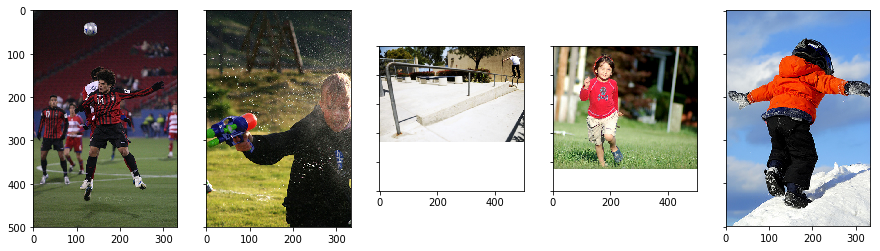

In [147]:
#Plotting last 10 images 
plot_image(all_imgs[5:10])

In [148]:
# Creating dataframe column of captions file for visulaizing
# Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.
import pandas as pd
captions_df = pd.read_csv(CAPTIONS_FILE)

pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption
print(captions_df.shape)
captions_df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


### Observation
There are 5 captions for each image.

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


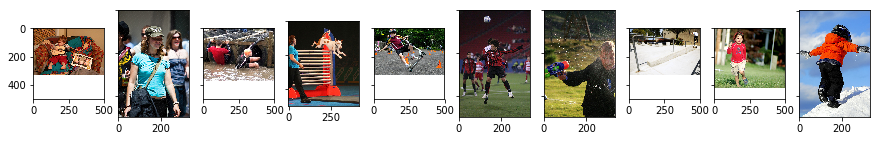

In [149]:
plot_image(all_imgs[:10])
captions_df.head(10)

In [150]:
# Reading captions file
file = open(caption_path)
captions_txt = file.read()
file.close()
img_cap_corpus=captions_txt.split('\n')
img_cap_corpus.pop(0)## poping first line names of columns (image,caption)

'image,caption'

### 1.3 Create a dataframe which summarizes the image, path & captions as a dataframe

In [151]:
datatxt = []
for line in img_cap_corpus:
    col = line.split(',')# Seperates columns image and caption
   
    if len(col)==1:
        continue
    w = col[0].split("_") # seperating image filename to extract the id 
   
    w[1] = image_path + col[0] # saving complete path of image file for building model
    datatxt.append(w + [col[1].lower()])

df= pd.DataFrame(datatxt,columns=['ID','Path','Captions'])
df.head()

,ID,Path,Captions
0,1000268201,Flickr8K/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201,Flickr8K/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,1000268201,Flickr8K/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,1000268201,Flickr8K/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .
4,1000268201,Flickr8K/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .


### Creating Vocab

In [152]:
#Lets store the dataframe variables

all_img_id= df.ID
all_img_vector= df.Path
annotations= df.Captions

In [153]:
#Lets generate the vocabulary

def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(captions):
      
    words = []

    for sentence in captions:
        sent_words = split_sentence(sentence)
        for word in sent_words: 
            words.append(word)
    return sorted(words)
    
vocab = generate_vocabulary(df.Captions)
vocab

['08',
 '1',
 '1',
 '10',
 '104',
 '11',
 '11',
 '12',
 '12',
 '12',
 '13',
 '13',
 '13406',
 '157',
 '19',
 '19',
 '19',
 '1915',
 '1923',
 '1950s',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2008',
 '21',
 '23',
 '23',
 '23',
 '25',
 '25',
 '25',
 '28',
 '28',
 '28',
 '281',
 '281',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '32',
 '33',
 '3rd',
 '3rd',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '42',
 '4x4',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '50',
 '52',
 '52',
 '57',
 '58',
 '58',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '625',
 '661',
 '7',
 '7',
 '75',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '80',
 '84',
 '84',
 '90',
 '93',
 '97',
 'a',
 'a',
 'a',
 'a

#### Creating captions Counter

In [154]:
vocabulary =  Counter(vocab)

df_word = pd.DataFrame.from_dict(vocabulary, orient='index')
df_word = df_word.sort_values(by=[0],ascending=False).reset_index()
df_word =df_word.rename(columns={'index':'word', 0:'count'})
df_word

,word,count
0,a,61436
1,in,18193
2,the,17677
3,on,10369
4,is,9069
5,and,8066
6,dog,7958
7,with,7308
8,man,7172
9,of,6504


### 1.4. Visualize the top 30 occuring words in the captions


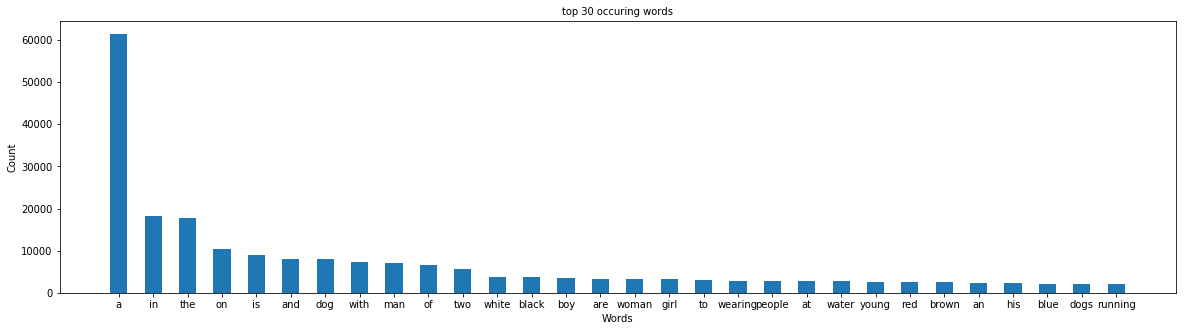

In [155]:
#Visualize the top 30 occuring words in the captions

def plot_30(index,words,count, title="top 30 occuring words"):
    plt.figure(figsize=(20,5))
    plt.bar(words,count, width =0.5)
    plt.xlabel("Words",  fontsize=10) 
    plt.ylabel("Count",fontsize=10) 
    
    plt.title(title,fontsize=10)
    plt.show()
    
words = list(df_word[:30].word)

count =list(df_word['count'][:30])
plot_30(list(range(0,30)),words,count)

### 5.Create a list which contains all the captions & path

In [156]:

#Adding start and end tokens
df['Captions']=df.Captions.apply(lambda x : f"<start> {x} <end>")
annotations = df['Captions']


# Find max length of the caption
max_length = max(df.Captions.apply(lambda x : len(x.split())))

#Create a list which contains all the UNIQUE path to the images
unique_img_path= sorted(set(all_img_vector))

In [157]:
#checking if the tokens got generated
df['Captions'].head()

0    <start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>
1    <start> a girl going into a wooden building . <end>                                   
2    <start> a little girl climbing into a wooden playhouse . <end>                        
3    <start> a little girl climbing the stairs to her playhouse . <end>                    
4    <start> a little girl in a pink dress going into a wooden cabin . <end>               
Name: Captions, dtype: object

## 2. Pre-Processing the captions
2.1 Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.2 Replace all other words with the unknown token "UNK" .

2.3 Create word-to-index and index-to-word mappings.

2.4 Pad all sequences to be the same length as the longest one.

### 2.1 Create the tokenizer
 Creating captions Counter, and dataframe of top 5000 frequently used words, for observation.

In [158]:
def data_shuffle(all_captions,all_img_vector):
    img_captions, img_name_vector = shuffle(all_captions,all_img_vector,random_state=42)
    return img_captions,img_name_vector

img_captions,all_img_vector = data_shuffle(annotations,all_img_vector)

In [159]:
def tokenize_captions(top_cap,captions):
    special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_freq_words,oov_token="UNK",filters=special_chars)
    tokenizer.fit_on_texts(captions)
    
    # Adding PAD to tokenizer list
    tokenizer.word_index['PAD'] = 0
    tokenizer.index_word[0] = 'PAD'   
   
    return tokenizer

In [160]:
# Pad each vector to the max_length of the captions
top_freq_words = 5000
tokenizer = tokenize_captions(top_freq_words,img_captions)

# Create the tokenized vectors
cap_seqs = tokenizer.texts_to_sequences(img_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')

In [161]:
# Maximum length of sequence 
max_length = max([len(cap) for cap in cap_seqs])
print("Maximium length of sequence = ", max_length)

Maximium length of sequence =  35


In [162]:
# Create word-to-index and index-to-word mappings.
def print_word_to_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))

          
print( "Word 2 index mapping")
print_word_to_index("<start>")
print_word_to_index("PAD")

Word 2 index mapping
Word = <start>, index = 3
Word = PAD, index = 0


In [163]:
# Create word-to-index and index-to-word mappings.
def print_index_to_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))

          
print( "Index 2 word mapping")
print_index_to_word(4)
print_index_to_word(1000)

Index 2 word mapping
Index = 4, Word = <end>
Index = 1000, Word = home


In [164]:
# Word count of your tokenizer to see the Top 30 occuring words after text processing
word_count = tokenizer.word_counts
import operator
word_count = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)
for k,v in word_count[:30]:
    print (k,v)

a 61436
<start> 40455
<end> 40455
in 18193
the 17677
on 10369
is 9069
and 8066
dog 7958
with 7308
man 7172
of 6504
two 5550
white 3728
black 3641
boy 3534
are 3365
woman 3320
girl 3284
to 3008
wearing 2917
people 2837
at 2820
water 2683
young 2610
red 2571
brown 2484
an 2358
his 2255
blue 2136


## 3. Pre-processing the images

## Load the pretrained Imagenet weights of Inception net V3

3.1 To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

3.2 Resize them into the shape of (299, 299)

3.3 Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 


In [165]:
#3.1 To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model InceptionV3

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [166]:
#3.2.Resize them into the shape of (299, 299) for InceptionV3

def preprocess_image(image_path):
    shape = (299, 299)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,shape)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

In [167]:
# Creating Image dataset of preprocessed images 

BATCH_SIZE = 64
shape = (299, 299)
encode = sorted (set(all_img_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [168]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299,299,3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)

In [169]:
image_train, image_test, captions_train, captions_test = train_test_split(all_img_vector,cap_vector, test_size=0.2, random_state=42)

In [170]:
# Deleting previously created  npy files
from glob import glob
all_output_imgs = glob(OUTPUT_IMAGE_PATH + '*.*')
print("The total images present in the dataset: {}".format(len(all_output_imgs)))
if len(all_output_imgs)> 0:
    print(all_output_imgs[0])
    for path in (all_output_imgs):
        os.remove(path)
all_output_imgs = glob(OUTPUT_IMAGE_PATH + '*.npy')

The total images present in the dataset: 8091
Flickr8K/Output/3072611047_109bf8b7c3.jpg.npy


In [171]:
#Creating a new directory with reshaped and normalized images

os.mkdir("Image")
all_imgs_npy = []
for img,path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        file_name = p.numpy().decode("utf-8").split('/')[-1]
        all_imgs_npy.append(file_name)
        np.save( OUTPUT_IMAGE_PATH +file_name, bf.numpy())

100%|██████████| 127/127 [16:43<00:00,  6.48s/it]


In [186]:
#Zipping the images in numpy vectors

img_to_cap_vector = collections.defaultdict(list)

for img,cap in zip(all_img_vector,cap_vector):
    img_to_cap_vector[img].append(cap)

img_to_cap_vector

defaultdict(list,
            {'Flickr8K/Images/2973269132_252bfd0160.jpg': [array([   3,    2,   55, 1591,  593,    8, 3971,    2,  224,  123,    2,
                     1455,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0], dtype=int32),
              array([   3,    2, 3196, 2813,    5,    7,   76, 2598,    4,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0], dtype=int32),
              array([   3,    6, 3196, 4898,    2,    1,    7,    2, 1128,    4,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0], dtype=int32),
          

In [187]:
#4.1 Combine both images & captions to create the train & test dataset using tf.data.Dataset API. 
#Create the train-test spliit using 80-20 ratio & random state = 42
tf.random.set_seed(42)
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
#print(img_name_train_keys, img_name_val_keys)
image_train = []
captions_train = []
for imgt in img_name_train_keys:
    captions_len = len(img_to_cap_vector[imgt])
    #print(captions_len)
    image_train.extend([imgt] * captions_len)
    captions_train.extend(img_to_cap_vector[imgt])

image_test = []
captions_test = []
for imgtest in img_name_val_keys:
    captions_len = len(img_to_cap_vector[imgtest])
    image_test.extend([imgtest] * captions_len)
    captions_test.extend(img_to_cap_vector[imgtest])

In [188]:
print("Image_train = {}, Captions_train = {}".format(len(image_train), len(captions_train)))

print("Image_test = {}, Captions_test = {}".format(len(image_test), len(captions_test)))

Image_train = 32360, Captions_train = 32360
Image_test = 8095, Captions_test = 8095


In [189]:
def get_file_name(filename):
    return (image_path + filename)

#Creating reverse vectorization with equalized length

def vector_to_sentence(caplist):
    captions_word =[]
    for captions in caplist:
        list_caption = list(captions)

        captions_word.append(' '.join(tokenizer.index_word[i] for i in list_caption))
    return captions_word

caplist_train = []
captions_word = vector_to_sentence(list(captions_train[:5]))
captions_word


['<start> a dog is chewing on a metal pole <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 '<start> brown puppy biting pole <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 '<start> brown dog chewing on a brown walking cane <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 '<start> a brown puppy is gnawing in a metallic post that is stuck into the ground <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 '<start> a puppy mouthing a pole on the ground <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD']

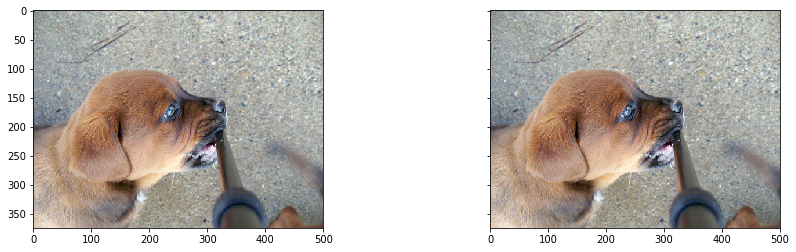

In [190]:
#print(image_train[28],image_train[29])
filename = (image_path + image_train[1].split('/')[-1]).replace(".npy","")
filename1 = (image_path + image_train[2].split('/')[-1]).replace(".npy","")

plot_image([filename,filename1],caplist_train)


# Extracting features from each image in the dataset

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

In [191]:
# Load the numpy files
def map_func(img_name, cap):
    filename = OUTPUT_IMAGE_PATH + img_name.decode('utf-8').split('/')[-1] + ".npy"
    img_tensor = np.load(filename)
    return img_tensor, cap

In [192]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = tf.data.Dataset.from_tensor_slices((image_train, captions_train))
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [193]:

test_dataset = tf.data.Dataset.from_tensor_slices((image_test, captions_test))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [194]:
train_img_batch, train_cap_batch = next(iter(train_dataset))
print(train_img_batch.shape) #(batch_size, 8*8,2048)
print(train_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 35)


In [195]:
test_img_batch, test_cap_batch = next(iter(test_dataset))
print(test_img_batch.shape) #(batch_size, 8*8,2048)
print(test_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [196]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000


# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

embedding_dim = 256 
units = 512
vocab_size = top_freq_words + 1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

## Encoder

## Attention Model

                                
*      Calculating the attention weights. 
    *     W1,W2, V must have matching leading dimensions 
    *     sequence length of W2 = sequence length of v
    *     Mask will have different shape based on look ahead or padding.


In [197]:
def padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(W1, W2, v, mask):
    matmul_W1W2 = tf.matmul(W1, W2, transpose_b=True)  # (..., seq_len_W1, seq_len_W2)
    dimW2 = tf.cast(tf.shape(W2)[-1], tf.float32)
    scaled_attention_logits = matmul_W1W2/ tf.math.sqrt(dimW2)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_W1, depth_v)

    return output, attention_weights

In [198]:
# Subclassing tensor layer to create multilayer Attention layer to be later  used in Attention Layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.W1 = tf.keras.layers.Dense(d_model)
        self.W2 = tf.keras.layers.Dense(d_model)
        self.Wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, W1, W2, mask=None):
        batch_size = tf.shape(q)[0]
        W1 = self.W1(W1)  # (batch_size, seq_len, d_model)
        W2 = self.W2(W2)  # (batch_size, seq_len, d_model)
        Wv = self.Wv(v)  # (batch_size, seq_len, d_model)

        W1 = self.split_heads(W1, batch_size)  # (batch_size, num_heads, seq_len_W1, depth)
        W2 = self.split_heads(W2, batch_size)  # (batch_size, num_heads, seq_len_W2, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(W1, W2, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

    def point_wise_feed_forward_network(d_model, dff):
        return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)


In [199]:
#### Creating Encoder layer subclass keras.layers
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [200]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [201]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [202]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [203]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embedding_dim)
        # shape after fc == (batch_size, 64, embedding_dim)
        #self.fc = tf.keras.layers.Dense(embedding_dim)
        #self.dropout = tf.keras.layers.Dropout(0.5,noise_shape=None,seed=None)
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [204]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

## Decoder

In [205]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size,embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        self.attention = Attention_model(self.units)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        x = self.d1(output)
        x = tf.reshape(x, (-1, x.shape[2])) # shape : (batch_size * max_length, hidden_size)
        x = self.d2(x) # shape : (batch_size * max_length, vocab_size)
        
        return x,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [206]:
encoder=Encoder(embedding_dim)
decoder=Decoder(embedding_dim, units, vocab_size)

In [207]:
features=encoder(train_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * train_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [208]:
class final_Model(tf.keras.Model):
    def __init__(self, embedding_dim,units,vocab_size, rate=0.1):
        super(final_Model, self).__init__()
        self.encoder = Encoder(embedding_dim)#, d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(embedding_dim, units, vocab_size)
        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
        enc_output = self.encoder(embeding_dim)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights = self.decoder(embeding_dim,units,vocab_size)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [209]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [210]:
learning_rate = CustomSchedule(embedding_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
metric = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [211]:
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction='none')#define your loss object
metric = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [212]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [213]:
checkpoint_path_ckpt = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer,
                           metrics=metric)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [214]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [215]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor,training =True)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    metric(loss)    
    return loss, total_loss

In [216]:
@tf.function
def test_step(img_tensor, target):
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            predicted_id = tf.argmax(predictions[0])
            dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)
   
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [217]:
def test_loss_cal(dataset):
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
   
    
    return total_loss/int(target.shape[1])

In [218]:
train_loss = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [219]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.976, & test loss is 7.427
Time taken for 1 epoch 1318.4717681407928 sec

Test loss has been reduced from 100.000 to 7.427


 13%|█▎        | 2/15 [41:56<4:37:52, 1282.51s/it]

For epoch: 2, the train loss is 0.900, & test loss is 7.707
Time taken for 1 epoch 1197.993411540985 sec



 20%|██        | 3/15 [1:01:55<4:11:30, 1257.52s/it]

For epoch: 3, the train loss is 0.841, & test loss is 7.873
Time taken for 1 epoch 1199.2083098888397 sec



 27%|██▋       | 4/15 [1:22:00<3:47:37, 1241.59s/it]

For epoch: 4, the train loss is 0.790, & test loss is 7.998
Time taken for 1 epoch 1204.412439107895 sec



 33%|███▎      | 5/15 [1:42:18<3:25:44, 1234.42s/it]

For epoch: 5, the train loss is 0.745, & test loss is 8.123
Time taken for 1 epoch 1217.672158241272 sec



 40%|████      | 6/15 [2:02:43<3:04:45, 1231.71s/it]

For epoch: 6, the train loss is 0.703, & test loss is 8.288
Time taken for 1 epoch 1225.4049263000488 sec



 47%|████▋     | 7/15 [2:22:41<2:42:52, 1221.58s/it]

For epoch: 7, the train loss is 0.667, & test loss is 8.633
Time taken for 1 epoch 1197.935832977295 sec



 53%|█████▎    | 8/15 [2:42:53<2:22:10, 1218.71s/it]

For epoch: 8, the train loss is 0.632, & test loss is 8.797
Time taken for 1 epoch 1212.0114595890045 sec



 60%|██████    | 9/15 [3:03:11<2:01:50, 1218.39s/it]

For epoch: 9, the train loss is 0.600, & test loss is 8.701
Time taken for 1 epoch 1217.6419355869293 sec



 67%|██████▋   | 10/15 [3:23:12<1:41:06, 1213.23s/it]

For epoch: 10, the train loss is 0.571, & test loss is 9.110
Time taken for 1 epoch 1201.19615650177 sec



 73%|███████▎  | 11/15 [3:43:12<1:20:37, 1209.26s/it]

For epoch: 11, the train loss is 0.544, & test loss is 9.473
Time taken for 1 epoch 1199.9921238422394 sec



 80%|████████  | 12/15 [4:03:29<1:00:34, 1211.60s/it]

For epoch: 12, the train loss is 0.517, & test loss is 9.579
Time taken for 1 epoch 1217.064553976059 sec



 87%|████████▋ | 13/15 [4:23:59<40:34, 1217.22s/it]  

For epoch: 13, the train loss is 0.494, & test loss is 9.767
Time taken for 1 epoch 1230.3149137496948 sec



 93%|█████████▎| 14/15 [4:44:51<20:27, 1227.61s/it]

For epoch: 14, the train loss is 0.473, & test loss is 10.008
Time taken for 1 epoch 1251.8531291484833 sec



100%|██████████| 15/15 [5:05:11<00:00, 1225.31s/it]

For epoch: 15, the train loss is 0.453, & test loss is 10.297
Time taken for 1 epoch 1219.9444768428802 sec



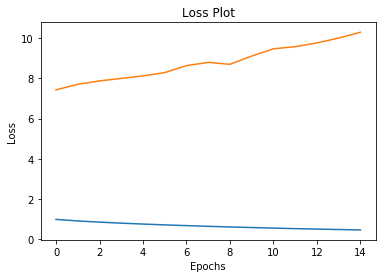

In [220]:
#Lets plot the train and test loss

plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

## Greedy Search

In [221]:
def init_features(image):
    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    return features,dec_input

In [222]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    features,dec_input = init_features(image)
    
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
       # print(predicted_id)
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if (tokenizer.index_word[predicted_id] == "<end>"):
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


## Beam Search

In [223]:
def beam_evaluate(image, beam_index = 3 ):#your value for beam index

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index["<start>"]]
    # result [i][0] : word index of the ith word in result
    # result [i][1] : probability of ith word being predicted
    result = [[start, 0.0]]
    attention_plot = np.zeros((max_length,attention_features_shape))  
    hidden = decoder.init_state(batch_size=1)
    features,dec_input = init_features(image)
    
    
    while len(result[0][0]) < max_length:
        i = 0 
        temp = []
        for s in result:
            preds, hidden, attention_weights = decoder(dec_input,features,hidden)
            attention_plot = tf.reshape(attention_w,(-1,)).numpy()
            i +=1
            # Getting the top <beam_index>(n) predictions and creating a 
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            
            # new list  to put in the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        result = temp
        # Sorting according to the probabilities
        result = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        pred_id = pred_list[-1]       
        if(pred_id ==3):
            break            
                  
        dec_input = tf.expand_dims([pred_id],0)
    
    result = result[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i == '<end>':
            break
        final_caption.append(i)
        
    attention_plot = attention_plot[:len(result),:]
    final_caption = ' '.join(final_caption[1:])
    return final_caption,attention_plot

In [224]:
def plot_attmap(caption, attention_plot, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(attention_plot[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((299, 299), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [225]:
# captions on the validation set
rid = np.random.randint(0, len(image_test))
image = image_test[rid]
#print(image)
image = IMAGE_PATH +(image.split('/')[-1]).replace(".npy","")
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test[rid] if i not in [0]])
result, weight,predictions = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))

Flickr8K/Images/160805827_5e6646b753.jpg
Real Caption: <start> a man sits on a boat in the sunset near a flag <end>
Prediction Caption: a man in a purple shirt is in a small girl in a pink scarf near a large rock in a picnic table and looks out of a city <end>


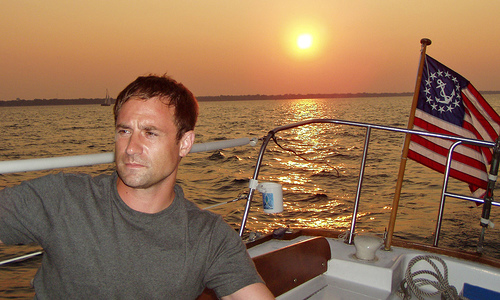

In [226]:
Image.open(image)

In [227]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [243]:
def filt_text(text):
    filt=['<start>','<unk>','<UNK>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

Flickr8K/Images/3339558806_b4afdc8394.jpg
a woman in a red shirt and bandanna and a girl in a blue shirt are sitting on a large swing in front of a house two kids playing on the swing
BELU score: 7.937727002553337e-308
Real Caption: a woman in a red shirt and bandanna and a girl in a blue shirt are sitting on a large swing in front of a house
Prediction Caption: two kids playing on the swing


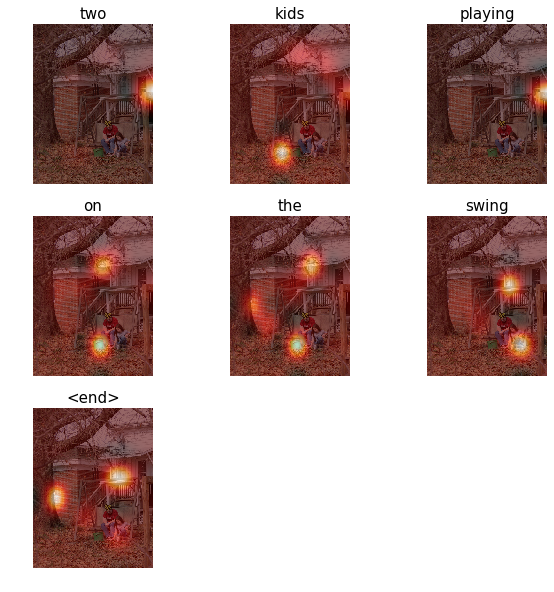

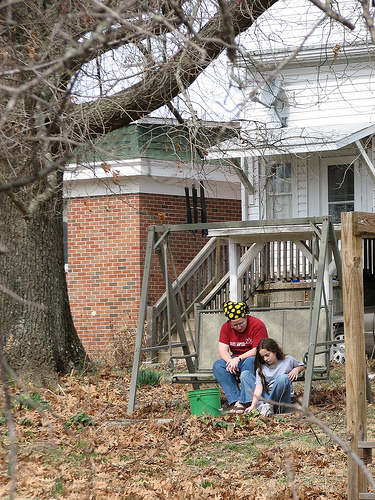

In [246]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
print(test_image)

real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test[rid] if i not in [0]])
result, weight,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
print(real_caption,pred_caption)
real_appn.append(real_caption.split())
reference = list(real_appn)
candidate = pred_caption.split()
#Cummunilative and n
score = sentence_bleu(reference, candidate, weights=(0,0,1,0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, weight, test_image)


Image.open(test_image)